In [1]:
import pandas as pd
import numpy as np
import math
import shutil
import glob
import os
import datetime as dt
import matplotlib.pyplot as plt
import multiprocessing as mp
import pyswmm
from pyswmm import Simulation, Links
import swmmio
import swmmio.utils.modify_model

In [2]:
pd.reset_option('^display.', silent=True)

# inputs

In [3]:
input_idf_table_file_path = './Assignment_3__Input_FE/Data_Centroid/BOM_IDF_Data/depths_-33.8774_151.093_all_design.csv'
input_temp_pattern_file_path = './Assignment_3__Input_FE/Data_Centroid/ECsouth/ECsouth_Increments.csv'
input_storm_stats_file_path = './Assignment_3__Input_FE/Data_Centroid/ECsouth/ECsouth_AllStats.csv'
output_dir = './Assignment_3__Output_FE__1st__centroid/'
original_inp_file_path = './Assignment_3__Input_FE/971007_SW5.INP'
simulation_starting_time = '2000/01/01 00:00:00'
stopping_time_after_precipitation_finish = {'days':0, 'hours':12, 'minutes':0, 'seconds':0}
report_step = {'days':0, 'hours':0, 'minutes':5, 'seconds':0}
wet_step = {'days':0, 'hours':0, 'minutes':5, 'seconds':0}
dry_step = {'days':0, 'hours':0, 'minutes':5, 'seconds':0}
routing_step = {'days':0, 'hours':0, 'minutes':0, 'seconds':30}
link_to_get_results = 116
timeseries_name = 'RainGauge'

simulation_starting_time = pd.to_datetime(simulation_starting_time)
stopping_time_after_precipitation_finish = pd.Timedelta(**stopping_time_after_precipitation_finish)
report_step = pd.Timedelta(**report_step)
wet_step = pd.Timedelta(**wet_step)
dry_step = pd.Timedelta(**dry_step)
routing_step = pd.Timedelta(**routing_step)
link_to_get_results = str(link_to_get_results)

print(
    input_idf_table_file_path,
    input_temp_pattern_file_path,
    input_storm_stats_file_path,
    original_inp_file_path,
    simulation_starting_time,
    stopping_time_after_precipitation_finish,
    report_step,
    wet_step,
    dry_step,
    routing_step,
    link_to_get_results,
    timeseries_name,
    sep='\n'
    )

./Assignment_3__Input_FE/Data_Centroid/BOM_IDF_Data/depths_-33.8774_151.093_all_design.csv
./Assignment_3__Input_FE/Data_Centroid/ECsouth/ECsouth_Increments.csv
./Assignment_3__Input_FE/Data_Centroid/ECsouth/ECsouth_AllStats.csv
./Assignment_3__Input_FE/971007_SW5.INP
2000-01-01 00:00:00
0 days 12:00:00
0 days 00:05:00
0 days 00:05:00
0 days 00:05:00
0 days 00:00:30
116
RainGauge


In [4]:
def create_output_dir(arg_output_dir):
    """create output directory if it does not exist

    arguments:
        [string] --> arg_output_dir = path of the output directory name
    """
    if not os.path.exists(arg_output_dir):
        os.makedirs(arg_output_dir)

In [5]:
create_output_dir(output_dir)
output_dir

'./Assignment_3__Output_FE__1st__centroid/'

In [6]:
inp_file_dir = '{}inp_file_dir/'.format(output_dir)
create_output_dir(inp_file_dir)
inp_file_dir

'./Assignment_3__Output_FE__1st__centroid/inp_file_dir/'

In [7]:
rain_pattern_cum_dir = '{}rain_pattern_cum_dir/'.format(output_dir)
create_output_dir(rain_pattern_cum_dir)
rain_pattern_cum_dir

'./Assignment_3__Output_FE__1st__centroid/rain_pattern_cum_dir/'

In [8]:
precipitation_dir = '{}precipitation_dir/'.format(output_dir)
create_output_dir(precipitation_dir)
precipitation_dir

'./Assignment_3__Output_FE__1st__centroid/precipitation_dir/'

In [9]:
flow_rate_dir = '{}flow_rate_dir/'.format(output_dir)
create_output_dir(flow_rate_dir)
flow_rate_dir

'./Assignment_3__Output_FE__1st__centroid/flow_rate_dir/'

In [186]:
graphs_pattern_dir = '{}graphs_pattern_dir/'.format(output_dir)
create_output_dir(graphs_pattern_dir)
graphs_pattern_dir

'./Assignment_3__Output_FE__1st__centroid/graphs_pattern_dir/'

In [189]:
graphs_frequency_dir = '{}graphs_frequency_dir/'.format(output_dir)
create_output_dir(graphs_frequency_dir)
graphs_frequency_dir

'./Assignment_3__Output_FE__1st__centroid/graphs_frequency_dir/'

In [188]:
results_frequency_dir = '{}results_frequency_dir/'.format(output_dir)
create_output_dir(results_frequency_dir)
results_frequency_dir

'./Assignment_3__Output_FE__1st__centroid/results_frequency_dir/'

# Threads

In [10]:
n_core = mp.cpu_count() - 1
n_core

13

# setting up the inp file

In [11]:
inp_file_path = '{}inp_template.inp'.format(output_dir)
inp_file_path

'./Assignment_3__Output_FE__1st__centroid/inp_template.inp'

In [12]:
# copy the original inp file
shutil.copyfile(src=original_inp_file_path, dst=inp_file_path)

'./Assignment_3__Output_FE__1st__centroid/inp_template.inp'

In [13]:
options_inp_file = swmmio.utils.dataframes.dataframe_from_inp(inp_path=inp_file_path, section='[OPTIONS]')
options_inp_file.at['START_DATE', 'Value'] = simulation_starting_time.strftime(format='%m/%d/%Y')
options_inp_file.at['START_TIME', 'Value'] = simulation_starting_time.strftime(format='%H:%M:%S')
options_inp_file.at['REPORT_START_DATE', 'Value'] = simulation_starting_time.strftime(format='%m/%d/%Y')
options_inp_file.at['REPORT_START_TIME', 'Value'] = simulation_starting_time.strftime(format='%H:%M:%S')
options_inp_file.at['END_DATE', 'Value'] = (simulation_starting_time + stopping_time_after_precipitation_finish).strftime(format='%m/%d/%Y')
options_inp_file.at['END_TIME', 'Value'] = (simulation_starting_time + stopping_time_after_precipitation_finish).strftime(format='%H:%M:%S')
options_inp_file.at['REPORT_STEP', 'Value'] = str(report_step).split(sep=' ')[-1]
options_inp_file.at['WET_STEP', 'Value'] = str(wet_step).split(sep=' ')[-1]
options_inp_file.at['DRY_STEP', 'Value'] = str(dry_step).split(sep=' ')[-1]
options_inp_file.at['ROUTING_STEP', 'Value'] = str(routing_step).split(sep=' ')[-1]
options_inp_file.at['THREADS', 'Value'] = n_core

options_inp_file

,Value
Key,
FLOW_UNITS,CMS
INFILTRATION,HORTON
FLOW_ROUTING,KINWAVE
LINK_OFFSETS,DEPTH
MIN_SLOPE,0
ALLOW_PONDING,NO
SKIP_STEADY_STATE,NO
START_DATE,01/01/2000
START_TIME,00:00:00


In [14]:
raingauges_inp_file = swmmio.utils.dataframes.dataframe_from_inp(inp_path=inp_file_path, section='[RAINGAGES]')
raingauges_inp_file = raingauges_inp_file.iloc[:1]
raingauges_inp_file.index = pd.Index(data=[timeseries_name], name='Name')
raingauges_inp_file.at[timeseries_name, 'TimeIntrvl'] = str(pd.Timedelta(minutes=5)).split(sep=' ')[-1].rsplit(sep=':', maxsplit=1)[0]
raingauges_inp_file.at[timeseries_name, 'DataSourceName'] = timeseries_name

raingauges_inp_file

,RainType,TimeIntrvl,SnowCatch,DataSource,DataSourceName
Name,,,,,
RainGauge,VOLUME,00:05,1.0,TIMESERIES,RainGauge


In [15]:
subcatchments_inp_file = swmmio.utils.dataframes.dataframe_from_inp(inp_path=inp_file_path, section='[SUBCATCHMENTS]')
subcatchments_inp_file.Raingage = timeseries_name

subcatchments_inp_file

,Raingage,Outlet,Area,PercImperv,Width,PercSlope,CurbLength
Name,,,,,,,
2101,RainGauge,101,8.46,33.5,300.0,3.50,0
2401,RainGauge,401,5.87,33.5,230.0,4.50,0
2102,RainGauge,102,5.87,33.5,100.0,4.80,0
2103,RainGauge,103,4.25,33.5,240.0,4.50,0
2104,RainGauge,104,12.22,33.5,500.0,4.00,0
...,...,...,...,...,...,...,...
2921,RainGauge,921,0.01,33.5,0.0,0.00,0
2922,RainGauge,922,0.01,33.5,0.0,0.00,0
2923,RainGauge,923,37.15,33.5,850.0,4.55,0


In [16]:
timeseries_inp_file = swmmio.utils.dataframes.dataframe_from_inp(inp_path=inp_file_path, section='[TIMESERIES]')
timeseries_inp_file.reset_index(inplace=True)
timeseries_inp_file.drop(index=timeseries_inp_file.index[1:], inplace=True)
timeseries_inp_file.at[0, 'Name'] = timeseries_name
timeseries_inp_file.set_index(keys='Name', inplace=True)
timeseries_inp_file.at[timeseries_name, 'Date'] = simulation_starting_time.strftime(format='%m/%d/%Y')
timeseries_inp_file.at[timeseries_name, 'Time'] = simulation_starting_time.strftime(format='%H:%M')
timeseries_inp_file.at[timeseries_name, 'Value'] = 0.0

timeseries_inp_file

,Date,Time,Value
Name,,,
RainGauge,01/01/2000,00:00,0.0


In [17]:
[swmmio.utils.modify_model.replace_inp_section(inp_path=inp_file_path, modified_section_header=ind1, new_data=ind2)
for ind1, ind2 in zip(
    ['[OPTIONS]', '[RAINGAGES]', '[SUBCATCHMENTS]', '[TIMESERIES]'], 
    [options_inp_file, raingauges_inp_file, subcatchments_inp_file, timeseries_inp_file]
    )]

# building idf table

In [18]:
idf_table = pd.read_csv(filepath_or_buffer=input_idf_table_file_path, skiprows=9)
frequency_label = idf_table.columns[2:].to_numpy()
idf_table.columns = idf_table.columns.to_series().apply(
    func=lambda arg: 
        '_'.join(arg.split(sep=' ')) 
        if arg[:8] == 'Duration' 
        else 'freq_' + '_'.join('_perc'.join('_'.join(arg.split(sep=' ')).split(sep='%')).split(sep='.'))
    )
frequency_tag = idf_table.columns[2:].to_numpy()
idf_table[['Duration', 'units']] = idf_table.apply(func=lambda arg: arg.Duration.split(sep=' '), axis=1, result_type='expand')
idf_table = idf_table[idf_table.columns[[0,-1] + list(range(1,len(idf_table.columns) - 1))]]
idf_table.Duration = idf_table.Duration.astype(float)
idf_table.to_csv(path_or_buf='{}table_idf_depths.csv'.format(output_dir), index=False)
idf_table.to_parquet(path='{}table_idf_depths.parquet'.format(output_dir))

idf_table

,Duration,units,Duration_in_min,freq_12EY,freq_6EY,freq_4EY,freq_3EY,freq_2EY,freq_63_2_perc,freq_50_perc,...,freq_20_perc,freq_0_2EY,freq_10_perc,freq_5_perc,freq_2_perc,freq_1_perc,freq_1_in_200,freq_1_in_500,freq_1_in_1000,freq_1_in_2000
0,1.0,min,1.0,0.999,1.13,1.37,1.55,1.80,2.28,2.51,...,3.25,3.31,3.74,4.22,4.84,5.32,5.82,6.58,7.17,7.76
1,2.0,min,2.0,1.770,2.00,2.39,2.67,3.07,3.77,4.10,...,5.14,5.25,5.86,6.57,7.52,8.25,9.08,10.30,11.30,12.20
2,3.0,min,3.0,2.410,2.73,3.29,3.68,4.25,5.23,5.71,...,7.21,7.35,8.23,9.24,10.60,11.60,12.80,14.50,15.80,17.10
3,4.0,min,4.0,2.960,3.36,4.07,4.58,5.30,6.56,7.19,...,9.15,9.33,10.50,11.80,13.50,14.90,16.30,18.40,20.10,21.80
4,5.0,min,5.0,3.430,3.91,4.76,5.37,6.23,7.75,8.52,...,10.90,11.10,12.60,14.10,16.20,17.80,19.50,22.10,24.00,26.10
5,10.0,min,10.0,5.150,5.91,7.28,8.27,9.70,12.20,13.60,...,17.60,18.00,20.40,23.00,26.40,29.00,31.60,35.80,39.00,42.20
6,15.0,min,15.0,6.290,7.25,8.96,10.20,12.00,15.30,16.90,...,22.00,22.50,25.50,28.70,33.00,36.20,39.60,44.70,48.70,52.80
7,20.0,min,20.0,7.160,8.26,10.20,11.70,13.70,17.50,19.40,...,25.20,25.70,29.10,32.80,37.70,41.40,45.20,51.20,55.70,60.40
8,25.0,min,25.0,7.860,9.07,11.20,12.80,15.10,19.30,21.40,...,27.70,28.30,31.90,36.00,41.30,45.30,49.60,56.10,61.20,66.30
9,30.0,min,30.0,8.460,9.76,12.10,13.80,16.30,20.80,23.00,...,29.70,30.30,34.20,38.60,44.30,48.60,53.20,60.20,65.60,71.10


# building temporal pattern table

In [19]:
temp_pattern_table = pd.read_csv(filepath_or_buffer=input_temp_pattern_file_path)
temp_pattern_table.rename(columns=lambda arg: arg.strip(), inplace=True)
# temp_pattern_table.rename(columns={'Duration':'Duration_in_min'}, inplace=True)
temp_pattern_table.columns = pd.Index(data=temp_pattern_table.columns[:5].to_list() + ['Increment_{:02}'.format(ind) for ind in range(len(temp_pattern_table.columns[5:]))])
temp_pattern_table.to_csv(path_or_buf='{}table_temp_patterns.csv'.format(output_dir), index=False)
temp_pattern_table.to_parquet(path='{}table_temp_patterns.parquet'.format(output_dir))

temp_pattern_table

,EventID,Duration,TimeStep,Region,AEP,Increment_00,Increment_01,Increment_02,Increment_03,Increment_04,...,Increment_46,Increment_47,Increment_48,Increment_49,Increment_50,Increment_51,Increment_52,Increment_53,Increment_54,Increment_55
0,4380,10,5,East Coast (South),frequent,58.06,41.94,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4382,10,5,East Coast (South),frequent,52.13,47.87,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4384,10,5,East Coast (South),frequent,60.71,39.29,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4385,10,5,East Coast (South),frequent,51.51,48.49,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4386,10,5,East Coast (South),frequent,54.55,45.45,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2856,10080,180,East Coast (South),rare,1.14,1.80,1.36,1.29,3.20,...,0.01,0.01,0.02,0.03,0.32,0.17,0.52,0.00,0.02,0.00
716,5064,10080,180,East Coast (South),rare,0.61,0.93,0.26,0.04,2.91,...,5.27,0.31,0.02,1.21,1.57,0.08,0.05,0.15,0.40,0.11
717,5069,10080,180,East Coast (South),rare,0.00,0.00,0.00,1.06,0.04,...,0.22,0.20,0.57,0.06,2.06,0.00,0.03,0.18,0.12,3.09
718,5071,10080,180,East Coast (South),rare,1.21,0.00,0.00,0.00,0.00,...,0.05,0.56,0.70,3.31,0.10,0.11,0.00,0.00,0.00,0.15


In [20]:
temp_pattern_table.dtypes

EventID           int64
Duration          int64
TimeStep          int64
Region           object
AEP              object
                 ...   
Increment_51    float64
Increment_52    float64
Increment_53    float64
Increment_54    float64
Increment_55    float64
Length: 61, dtype: object

In [21]:
storm_stats_table = pd.read_csv(filepath_or_buffer=input_storm_stats_file_path)
storm_stats_table.rename(columns=lambda arg: arg.strip(), inplace=True)
for ind in [(' ','_'), ('(',''), (')',''), ('%','in_perc'), ('_No.','_Number'), ('_min','_in_min'), ('_mm','_in_mm')]:
    storm_stats_table.rename(columns=lambda arg: arg.replace(*ind), inplace=True)
# storm_stats_table.rename(columns={'Burst_Duration_in_min':'Duration_in_min'}, inplace=True)
storm_stats_table.dropna(axis=0, inplace=True)
storm_stats_table.Burst_Start_Date = pd.to_datetime(arg=storm_stats_table.Burst_Start_Date, format='%m/%d/%Y %H:%M')
storm_stats_table.Burst_End_Date = pd.to_datetime(arg=storm_stats_table.Burst_End_Date, format='%m/%d/%Y %H:%M')
storm_stats_table.Event_ID = storm_stats_table.Event_ID.astype(int)
storm_stats_table.Burst_Duration_in_min = storm_stats_table.Burst_Duration_in_min.astype(int)
storm_stats_table.Burst_Loading = storm_stats_table.Burst_Loading.astype(int)
storm_stats_table.DB_Event_Reference_Number = storm_stats_table.DB_Event_Reference_Number.astype(int)
storm_stats_table.DB_Pluviograph_Reference_Number = storm_stats_table.DB_Pluviograph_Reference_Number.astype(int)
storm_stats_table.to_csv(path_or_buf='{}table_storm_stats.csv'.format(output_dir), index=False)
storm_stats_table.to_parquet(path='{}table_storm_stats.parquet'.format(output_dir))

storm_stats_table

,Event_ID,Region,Region_source,Burst_Duration_in_min,Burst_Loading,Original_Burst_Depth_in_mm,AEP_Window,AEP_source_in_perc,Burst_Start_Date,Burst_End_Date,DB_Event_Reference_Number,DB_Pluviograph_Reference_Number,Offical_Gauge,Lat,Long
0,4380,East Coast (South),East Coast (South),10,1,15.50,frequent,14.4679,2009-03-25 17:45:00,2009-03-25 17:50:00,113650,1828,qcd_563064_233,-32.2375,150.6306
1,4382,East Coast (South),East Coast (South),10,1,18.80,frequent,14.4924,1999-12-28 17:05:00,1999-12-28 17:10:00,39777,517,qcd_061250,-32.6296,151.5919
2,4384,East Coast (South),East Coast (South),10,1,16.80,frequent,14.5144,2005-02-04 09:30:00,2005-02-04 09:35:00,42925,556,qcd_068102,-34.4869,150.4019
3,4385,East Coast (South),East Coast (South),10,2,18.50,frequent,15.6473,1999-03-27 22:30:00,1999-03-27 22:35:00,114063,1835,qcd_563079_231,-33.7944,150.5083
4,4386,East Coast (South),East Coast (South),10,2,11.00,frequent,47.6798,1993-04-28 14:05:00,1993-04-28 14:10:00,113366,1824,qcd_563056_231,-34.0333,150.2153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2856,East Coast (South),East Coast (North),10080,1,595.23,rare,1.0865,1996-05-01 00:05:00,1996-05-08 00:00:00,26738,351,qcd_040223,-27.4178,153.1142
716,5064,East Coast (South),East Coast (North),10080,2,589.88,rare,1.2899,1968-01-06 17:10:00,1968-01-13 17:05:00,24711,329,qcd_040093,-26.1831,152.6414
717,5069,East Coast (South),East Coast (North),10080,2,491.26,rare,2.7020,1968-01-06 04:10:00,1968-01-13 04:05:00,23354,313,qcd_039128,-24.9069,152.3230
718,5071,East Coast (South),East Coast (North),10080,2,400.84,rare,2.9538,1968-01-07 11:45:00,1968-01-14 11:40:00,27412,358,qcd_040318,-27.0258,152.5642


# building frequency classification table

In [22]:
ey_constants = np.array(object=[12,6,4,3,2,1,0.5,0.2])
ey_constants

array([12. ,  6. ,  4. ,  3. ,  2. ,  1. ,  0.5,  0.2])

In [23]:
aep_variables = np.multiply(np.add(1, np.negative(np.exp(np.negative(ey_constants)))),100)
aep_variables

array([99.99938558, 99.75212478, 98.16843611, 95.02129316, 86.46647168,
       63.21205588, 39.34693403, 18.12692469])

In [24]:
aep_constants = np.array(object=[50, 20, 10, 5, 2, 1, 0.5, 0.2, 0.1, 0.05, 0.02])
aep_constants

array([5.e+01, 2.e+01, 1.e+01, 5.e+00, 2.e+00, 1.e+00, 5.e-01, 2.e-01,
       1.e-01, 5.e-02, 2.e-02])

In [25]:
ey_variables = np.negative(np.log(np.add(1, np.negative(np.divide(aep_constants, 100)))))
ey_variables

array([6.93147181e-01, 2.23143551e-01, 1.05360516e-01, 5.12932944e-02,
       2.02027073e-02, 1.00503359e-02, 5.01254182e-03, 2.00200267e-03,
       1.00050033e-03, 5.00125042e-04, 2.00020003e-04])

In [26]:
ey = np.flip(m=np.sort(a=np.concatenate((ey_constants, ey_variables))))
ey

array([1.20000000e+01, 6.00000000e+00, 4.00000000e+00, 3.00000000e+00,
       2.00000000e+00, 1.00000000e+00, 6.93147181e-01, 5.00000000e-01,
       2.23143551e-01, 2.00000000e-01, 1.05360516e-01, 5.12932944e-02,
       2.02027073e-02, 1.00503359e-02, 5.01254182e-03, 2.00200267e-03,
       1.00050033e-03, 5.00125042e-04, 2.00020003e-04])

In [27]:
aep_percentage = np.flip(m=np.sort(a=np.concatenate((aep_constants, aep_variables))))
aep_percentage

array([9.99993856e+01, 9.97521248e+01, 9.81684361e+01, 9.50212932e+01,
       8.64664717e+01, 6.32120559e+01, 5.00000000e+01, 3.93469340e+01,
       2.00000000e+01, 1.81269247e+01, 1.00000000e+01, 5.00000000e+00,
       2.00000000e+00, 1.00000000e+00, 5.00000000e-01, 2.00000000e-01,
       1.00000000e-01, 5.00000000e-02, 2.00000000e-02])

In [28]:
aep_1_in_x = np.divide(100, aep_percentage)
aep_1_in_x

array([1.00000614e+00, 1.00248491e+00, 1.01865736e+00, 1.05239570e+00,
       1.15651764e+00, 1.58197671e+00, 2.00000000e+00, 2.54149408e+00,
       5.00000000e+00, 5.51665557e+00, 1.00000000e+01, 2.00000000e+01,
       5.00000000e+01, 1.00000000e+02, 2.00000000e+02, 5.00000000e+02,
       1.00000000e+03, 2.00000000e+03, 5.00000000e+03])

In [29]:
ari = np.divide(1,ey)
ari

array([8.33333333e-02, 1.66666667e-01, 2.50000000e-01, 3.33333333e-01,
       5.00000000e-01, 1.00000000e+00, 1.44269504e+00, 2.00000000e+00,
       4.48142012e+00, 5.00000000e+00, 9.49122158e+00, 1.94957257e+01,
       4.94983165e+01, 9.94991625e+01, 1.99499582e+02, 4.99499833e+02,
       9.99499917e+02, 1.99949996e+03, 4.99949998e+03])

In [30]:
aep_percentage

array([9.99993856e+01, 9.97521248e+01, 9.81684361e+01, 9.50212932e+01,
       8.64664717e+01, 6.32120559e+01, 5.00000000e+01, 3.93469340e+01,
       2.00000000e+01, 1.81269247e+01, 1.00000000e+01, 5.00000000e+00,
       2.00000000e+00, 1.00000000e+00, 5.00000000e-01, 2.00000000e-01,
       1.00000000e-01, 5.00000000e-02, 2.00000000e-02])

In [31]:
frequency_window = np.array(object=['frequent', 'intermediate', 'rare'])[
    np.add(np.digitize(x=aep_percentage, bins=np.array(object=[100, 14.4, 3.2, 0]), right=False), np.negative(1))
    ]
frequency_window

array(['frequent', 'frequent', 'frequent', 'frequent', 'frequent',
       'frequent', 'frequent', 'frequent', 'frequent', 'frequent',
       'intermediate', 'intermediate', 'rare', 'rare', 'rare', 'rare',
       'rare', 'rare', 'rare'], dtype='<U12')

In [32]:
frequency_tag = np.concatenate((frequency_tag, np.array(object=['freq_1_in_5000'])))
frequency_tag

array(['freq_12EY', 'freq_6EY', 'freq_4EY', 'freq_3EY', 'freq_2EY',
       'freq_63_2_perc', 'freq_50_perc', 'freq_0_5EY', 'freq_20_perc',
       'freq_0_2EY', 'freq_10_perc', 'freq_5_perc', 'freq_2_perc',
       'freq_1_perc', 'freq_1_in_200', 'freq_1_in_500', 'freq_1_in_1000',
       'freq_1_in_2000', 'freq_1_in_5000'], dtype=object)

In [33]:
frequency_label = np.concatenate((frequency_label, np.array(object=['1 in 5000'])))
frequency_label

array(['12EY', '6EY', '4EY', '3EY', '2EY', '63.2%', '50%', '0.5EY', '20%',
       '0.2EY', '10%', '5%', '2%', '1%', '1 in 200', '1 in 500',
       '1 in 1000', '1 in 2000', '1 in 5000'], dtype=object)

In [34]:
frequency_table = pd.DataFrame(
    data=np.column_stack(tup=(ey, aep_percentage, aep_1_in_x, ari, frequency_window, frequency_label, frequency_tag)),
    columns=['EY', 'AEP_percentage', 'AEP_1_in_x', 'ARI', 'freq_window', 'freq_label', 'freq_tag']
    )
frequency_table.to_csv(path_or_buf='{}table_frequency.csv'.format(output_dir), index=False)
frequency_table.to_parquet(path='{}table_frequency.parquet'.format(output_dir))
frequency_table

,EY,AEP_percentage,AEP_1_in_x,ARI,freq_window,freq_label,freq_tag
0,12.0,99.999386,1.000006,0.083333,frequent,12EY,freq_12EY
1,6.0,99.752125,1.002485,0.166667,frequent,6EY,freq_6EY
2,4.0,98.168436,1.018657,0.25,frequent,4EY,freq_4EY
3,3.0,95.021293,1.052396,0.333333,frequent,3EY,freq_3EY
4,2.0,86.466472,1.156518,0.5,frequent,2EY,freq_2EY
5,1.0,63.212056,1.581977,1.0,frequent,63.2%,freq_63_2_perc
6,0.693147,50.0,2.0,1.442695,frequent,50%,freq_50_perc
7,0.5,39.346934,2.541494,2.0,frequent,0.5EY,freq_0_5EY
8,0.223144,20.0,5.0,4.48142,frequent,20%,freq_20_perc
9,0.2,18.126925,5.516656,5.0,frequent,0.2EY,freq_0_2EY


In [35]:
r_ey = ey.copy()
r_ey[:14] = r_ey[:14].round(decimals=2)
r_ey[14:17] = r_ey[14:17].round(decimals=3)
r_ey[17:] = r_ey[17:].round(decimals=4)
r_ey

array([1.2e+01, 6.0e+00, 4.0e+00, 3.0e+00, 2.0e+00, 1.0e+00, 6.9e-01,
       5.0e-01, 2.2e-01, 2.0e-01, 1.1e-01, 5.0e-02, 2.0e-02, 1.0e-02,
       5.0e-03, 2.0e-03, 1.0e-03, 5.0e-04, 2.0e-04])

In [36]:
r_aep_percentage = aep_percentage.copy()
r_aep_percentage = r_aep_percentage.round(decimals=2)
r_aep_percentage

array([1.000e+02, 9.975e+01, 9.817e+01, 9.502e+01, 8.647e+01, 6.321e+01,
       5.000e+01, 3.935e+01, 2.000e+01, 1.813e+01, 1.000e+01, 5.000e+00,
       2.000e+00, 1.000e+00, 5.000e-01, 2.000e-01, 1.000e-01, 5.000e-02,
       2.000e-02])

In [37]:
r_aep_1_in_x = aep_1_in_x.copy()
r_aep_1_in_x[:2] = r_aep_1_in_x[:2].round(decimals=3)
r_aep_1_in_x[2:] = r_aep_1_in_x[2:].round(decimals=2)
r_aep_1_in_x

array([1.000e+00, 1.002e+00, 1.020e+00, 1.050e+00, 1.160e+00, 1.580e+00,
       2.000e+00, 2.540e+00, 5.000e+00, 5.520e+00, 1.000e+01, 2.000e+01,
       5.000e+01, 1.000e+02, 2.000e+02, 5.000e+02, 1.000e+03, 2.000e+03,
       5.000e+03])

In [38]:
r_ari = ari.copy()
r_ari = r_ari.round(decimals=2)
r_ari

array([8.0000e-02, 1.7000e-01, 2.5000e-01, 3.3000e-01, 5.0000e-01,
       1.0000e+00, 1.4400e+00, 2.0000e+00, 4.4800e+00, 5.0000e+00,
       9.4900e+00, 1.9500e+01, 4.9500e+01, 9.9500e+01, 1.9950e+02,
       4.9950e+02, 9.9950e+02, 1.9995e+03, 4.9995e+03])

In [39]:
r_frequency_table = pd.DataFrame(
    data=np.column_stack(tup=(r_ey, r_aep_percentage, r_aep_1_in_x, r_ari, frequency_window, frequency_label, frequency_tag)),
    columns=['EY', 'AEP_percentage', 'AEP_1_in_x', 'ARI', 'freq_window', 'freq_label', 'freq_tag']
    )
r_frequency_table.to_csv(path_or_buf='{}table_rounded_frequency.csv'.format(output_dir), index=False)
r_frequency_table.to_parquet(path='{}table_rounded_frequency.parquet'.format(output_dir))
r_frequency_table

,EY,AEP_percentage,AEP_1_in_x,ARI,freq_window,freq_label,freq_tag
0,12.0,100.0,1.0,0.08,frequent,12EY,freq_12EY
1,6.0,99.75,1.002,0.17,frequent,6EY,freq_6EY
2,4.0,98.17,1.02,0.25,frequent,4EY,freq_4EY
3,3.0,95.02,1.05,0.33,frequent,3EY,freq_3EY
4,2.0,86.47,1.16,0.5,frequent,2EY,freq_2EY
5,1.0,63.21,1.58,1.0,frequent,63.2%,freq_63_2_perc
6,0.69,50.0,2.0,1.44,frequent,50%,freq_50_perc
7,0.5,39.35,2.54,2.0,frequent,0.5EY,freq_0_5EY
8,0.22,20.0,5.0,4.48,frequent,20%,freq_20_perc
9,0.2,18.13,5.52,5.0,frequent,0.2EY,freq_0_2EY


# merge stats and pattern tables into timeseries

In [40]:
{key:val for key,val in enumerate(storm_stats_table.columns)}

{0: 'Event_ID',
 1: 'Region',
 2: 'Region_source',
 3: 'Burst_Duration_in_min',
 4: 'Burst_Loading',
 5: 'Original_Burst_Depth_in_mm',
 6: 'AEP_Window',
 7: 'AEP_source_in_perc',
 8: 'Burst_Start_Date',
 9: 'Burst_End_Date',
 10: 'DB_Event_Reference_Number',
 11: 'DB_Pluviograph_Reference_Number',
 12: 'Offical_Gauge',
 13: 'Lat',
 14: 'Long'}

In [41]:
df_storm_stats = storm_stats_table.copy()
df_storm_stats.drop(columns=storm_stats_table.columns[[1,2,4,5,7,8,9,10,11,12,13,14]], inplace=True)
df_storm_stats.rename(columns={'Event_ID':'event_id', 'Burst_Duration_in_min':'duration_in_min', 'AEP_Window':'freq_window'}, inplace=True)
df_storm_stats['id_duration'] = pd.Series(data=np.unique(ar=df_storm_stats.duration_in_min.to_numpy(), return_inverse=True)[1])
df_storm_stats['id_window'] = pd.Series(data=np.unique(ar=df_storm_stats.freq_window.to_numpy(), return_inverse=True)[1])
df_storm_stats['id_pattern'] = pd.Series(data=list(np.arange(stop=10))*int(len(df_storm_stats)/10))

df_storm_stats

,event_id,duration_in_min,freq_window,id_duration,id_window,id_pattern
0,4380,10,frequent,0,0,0
1,4382,10,frequent,0,0,1
2,4384,10,frequent,0,0,2
3,4385,10,frequent,0,0,3
4,4386,10,frequent,0,0,4
...,...,...,...,...,...,...
715,2856,10080,rare,23,2,5
716,5064,10080,rare,23,2,6
717,5069,10080,rare,23,2,7
718,5071,10080,rare,23,2,8


In [42]:
df_temp_pattern = temp_pattern_table.copy()
df_temp_pattern['time_series'] = df_temp_pattern.apply(func=lambda arg: [ind for ind in arg.to_list()[5:] if str(ind) != 'nan'], axis=1)
df_temp_pattern.drop(columns=df_temp_pattern.columns[5:-1], inplace=True)
df_temp_pattern.drop(columns='Region', inplace=True)
df_temp_pattern.rename(columns={'EventID':'event_id', 'Duration':'duration_in_min', 'TimeStep':'time_step', 'AEP':'freq_window'}, inplace=True)
df_temp_pattern['id_duration'] = pd.Series(data=np.unique(ar=df_temp_pattern.duration_in_min.to_numpy(), return_inverse=True)[1])
df_temp_pattern['id_timestep'] = pd.Series(data=np.unique(ar=df_temp_pattern.time_step.to_numpy(), return_inverse=True)[1])
df_temp_pattern['id_window'] = pd.Series(data=np.unique(ar=df_temp_pattern.freq_window.to_numpy(), return_inverse=True)[1])
df_temp_pattern['id_pattern'] = pd.Series(data=list(np.arange(stop=10))*int(len(df_temp_pattern)/10))

df_temp_pattern

,event_id,duration_in_min,time_step,freq_window,time_series,id_duration,id_timestep,id_window,id_pattern
0,4380,10,5,frequent,"[58.06, 41.94]",0,0,0,0
1,4382,10,5,frequent,"[52.13, 47.87]",0,0,0,1
2,4384,10,5,frequent,"[60.71, 39.29]",0,0,0,2
3,4385,10,5,frequent,"[51.51, 48.49]",0,0,0,3
4,4386,10,5,frequent,"[54.55, 45.45]",0,0,0,4
...,...,...,...,...,...,...,...,...,...
715,2856,10080,180,rare,"[1.14, 1.8, 1.36, 1.29, 3.2, 4.78, 3.28, 3.13,...",23,5,2,5
716,5064,10080,180,rare,"[0.61, 0.93, 0.26, 0.04, 2.91, 1.17, 4.05, 0.1...",23,5,2,6
717,5069,10080,180,rare,"[0.0, 0.0, 0.0, 1.06, 0.04, 0.41, 0.71, 0.01, ...",23,5,2,7
718,5071,10080,180,rare,"[1.21, 0.0, 0.0, 0.0, 0.0, 0.04, 0.52, 2.96, 1...",23,5,2,8


In [43]:
{key:val for key,val in enumerate(df_temp_pattern)}

{0: 'event_id',
 1: 'duration_in_min',
 2: 'time_step',
 3: 'freq_window',
 4: 'time_series',
 5: 'id_duration',
 6: 'id_timestep',
 7: 'id_window',
 8: 'id_pattern'}

In [44]:
df_timeseries = pd.merge(left=df_storm_stats, right=df_temp_pattern, how='inner', on='event_id', suffixes=(None, '__del'))# left_on='Event_ID', right_on='EventID')
df_timeseries.drop(columns=[ind for ind in df_timeseries.columns.to_list() if ind.rsplit(sep='__', maxsplit=1)[-1] == 'del'], inplace=True)

df_timeseries

,event_id,duration_in_min,freq_window,id_duration,id_window,id_pattern,time_step,time_series,id_timestep
0,4380,10,frequent,0,0,0,5,"[58.06, 41.94]",0
1,4382,10,frequent,0,0,1,5,"[52.13, 47.87]",0
2,4384,10,frequent,0,0,2,5,"[60.71, 39.29]",0
3,4385,10,frequent,0,0,3,5,"[51.51, 48.49]",0
4,4386,10,frequent,0,0,4,5,"[54.55, 45.45]",0
...,...,...,...,...,...,...,...,...,...
715,2856,10080,rare,23,2,5,180,"[1.14, 1.8, 1.36, 1.29, 3.2, 4.78, 3.28, 3.13,...",5
716,5064,10080,rare,23,2,6,180,"[0.61, 0.93, 0.26, 0.04, 2.91, 1.17, 4.05, 0.1...",5
717,5069,10080,rare,23,2,7,180,"[0.0, 0.0, 0.0, 1.06, 0.04, 0.41, 0.71, 0.01, ...",5
718,5071,10080,rare,23,2,8,180,"[1.21, 0.0, 0.0, 0.0, 0.0, 0.04, 0.52, 2.96, 1...",5


In [45]:
{key:val for key,val in enumerate(df_timeseries)}

{0: 'event_id',
 1: 'duration_in_min',
 2: 'freq_window',
 3: 'id_duration',
 4: 'id_window',
 5: 'id_pattern',
 6: 'time_step',
 7: 'time_series',
 8: 'id_timestep'}

# idf depths

In [46]:
df_timeseries.columns

Index(['event_id', 'duration_in_min', 'freq_window', 'id_duration',
       'id_window', 'id_pattern', 'time_step', 'time_series', 'id_timestep'],
      dtype='object')

In [47]:
df_map = df_timeseries.copy()
df_map = df_map[['duration_in_min', 'time_step']]
df_map.reset_index(drop=True, inplace=True)
df_map = {key:val for key,val in zip(df_map.duration_in_min, df_map.time_step)}

df_map

{10: 5,
 15: 5,
 20: 5,
 25: 5,
 30: 5,
 45: 5,
 60: 5,
 90: 5,
 120: 5,
 180: 15,
 270: 15,
 360: 15,
 540: 30,
 720: 30,
 1080: 60,
 1440: 60,
 1800: 120,
 2160: 120,
 2880: 120,
 4320: 180,
 5760: 180,
 7200: 180,
 8640: 180,
 10080: 180}

In [48]:
df_id = frequency_table.copy()
df_id.drop(index=len(df_id)-1, inplace=True)
df_id = df_id[['freq_window', 'freq_label', 'freq_tag']]#.iloc[:-1,4:]
df_id = pd.concat(objs=[
    pd.Series(data=np.full(shape=len(df_id), fill_value='depth')),
    df_id,
    pd.Series(data=np.unique(ar=df_id.freq_window.to_numpy(), return_inverse=True)[1], name='id_window'),
    df_id.index.to_series(name='id_tag')
    ], axis=1)

df_id

,0,freq_window,freq_label,freq_tag,id_window,id_tag
0,depth,frequent,12EY,freq_12EY,0,0
1,depth,frequent,6EY,freq_6EY,0,1
2,depth,frequent,4EY,freq_4EY,0,2
3,depth,frequent,3EY,freq_3EY,0,3
4,depth,frequent,2EY,freq_2EY,0,4
5,depth,frequent,63.2%,freq_63_2_perc,0,5
6,depth,frequent,50%,freq_50_perc,0,6
7,depth,frequent,0.5EY,freq_0_5EY,0,7
8,depth,frequent,20%,freq_20_perc,0,8
9,depth,frequent,0.2EY,freq_0_2EY,0,9


In [49]:
df_idf = idf_table.copy()
df_idf = df_idf[df_idf.Duration_in_min >= 10]
df_idf.reset_index(drop=True, inplace=True)
df_idf.rename(columns={'Duration':'duration', 'Duration_in_min':'duration_in_min'}, inplace=True)
df_idf.duration_in_min = df_idf.duration_in_min.astype(int)
df_idf['id_duration'] = pd.Series(data=np.unique(ar=df_idf.duration_in_min.to_numpy(), return_inverse=True)[1])
df_idf['time_step'] = df_idf.duration_in_min.map(arg=df_map)
df_idf['id_timestep'] = pd.Series(data=np.unique(ar=df_idf.time_step.to_numpy(), return_inverse=True)[1])
df_idf.set_index(keys=[ind for ind in df_idf.columns.to_list() if ind.split(sep='_', maxsplit=1)[0] == 'id'] + ['duration', 'units', 'duration_in_min', 'time_step'] , inplace=True)
df_idf.columns = pd.MultiIndex.from_frame(df=df_id)
df_idf = df_idf.stack(level=list(df_idf.columns.names)[1:], future_stack=True)
df_idf.reset_index(inplace=True)

df_idf

,id_duration,id_timestep,duration,units,duration_in_min,time_step,freq_window,freq_label,freq_tag,id_window,id_tag,depth
0,0,0,10.0,min,10,5,frequent,12EY,freq_12EY,0,0,5.15
1,0,0,10.0,min,10,5,frequent,6EY,freq_6EY,0,1,5.91
2,0,0,10.0,min,10,5,frequent,4EY,freq_4EY,0,2,7.28
3,0,0,10.0,min,10,5,frequent,3EY,freq_3EY,0,3,8.27
4,0,0,10.0,min,10,5,frequent,2EY,freq_2EY,0,4,9.70
...,...,...,...,...,...,...,...,...,...,...,...,...
427,23,5,168.0,hour,10080,180,rare,1%,freq_1_perc,2,13,462.00
428,23,5,168.0,hour,10080,180,rare,1 in 200,freq_1_in_200,2,14,514.00
429,23,5,168.0,hour,10080,180,rare,1 in 500,freq_1_in_500,2,15,578.00
430,23,5,168.0,hour,10080,180,rare,1 in 1000,freq_1_in_1000,2,16,628.00


# rainfall_patterns

In [50]:
rain_data = pd.merge(left=df_timeseries, right=df_idf, how='cross', suffixes=[None, '__del'])
rain_data = rain_data[
    (rain_data.id_window == rain_data.id_window__del) & 
    (rain_data.id_duration == rain_data.id_duration__del) & 
    (rain_data.id_timestep == rain_data.id_timestep__del)
    ]
rain_data.drop(columns=[ind for ind in rain_data.columns.to_list() if ind.rsplit(sep='__', maxsplit=1)[-1] == 'del'], inplace=True)
rain_data.drop(columns='event_id', inplace=True)
rain_data.drop_duplicates(subset=list(rain_data.columns.to_numpy()[~np.isin(element=rain_data.columns.to_numpy(), test_elements='time_series')]), inplace=True)
rain_data.sort_values(by=['id_tag', 'id_duration', 'id_timestep', 'id_pattern'], inplace=True)
rain_data.reset_index(drop=True, inplace=True)
rain_data['id_group'] = pd.Series(data=np.concatenate([np.full(shape=10, fill_value=ind) for ind in np.arange(stop=np.divide(rain_data.shape[0], 10), dtype=np.int64)]))
rain_data['rain_label'] = (
    (rain_data.id_group.astype(str).str.len().max() - rain_data.id_group.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_group)) + rain_data.id_group.astype(str) + '__' +
    (rain_data.index.astype(str).str.len().max() - rain_data.index.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.index)) + rain_data.index.astype(str) + '__' +
    (rain_data.id_tag.astype(str).str.len().max() - rain_data.id_tag.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_tag)) + rain_data.id_tag.astype(str) + '_' +
    (rain_data.id_duration.astype(str).str.len().max() - rain_data.id_duration.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_duration)) + rain_data.id_duration.astype(str) + '_' +
    (rain_data.id_timestep.astype(str).str.len().max() - rain_data.id_timestep.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_timestep)) + rain_data.id_timestep.astype(str) + '_' +
    (rain_data.id_pattern.astype(str).str.len().max() - rain_data.id_pattern.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_pattern)) + rain_data.id_pattern.astype(str) + '__' +
    (rain_data.id_window.astype(str).str.len().max() - rain_data.id_window.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_window)) + rain_data.id_window.astype(str) + '__' +
    (rain_data.freq_window.str.len().max() - rain_data.freq_window.str.len())*pd.Series(data=['_']*len(rain_data.freq_window)) + rain_data.freq_window + '__' +
    (rain_data.freq_tag.str.len().max() - rain_data.freq_tag.str.len())*pd.Series(data=['_']*len(rain_data.freq_tag)) + rain_data.freq_tag + '__' +
    (rain_data.duration_in_min.astype(str).str.len().max() - rain_data.duration_in_min.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.duration_in_min)) + rain_data.duration_in_min.astype(str) + '__' +
    (rain_data.time_step.astype(str).str.len().max() - rain_data.time_step.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.time_step)) + rain_data.time_step.astype(str) + '__' +
    (rain_data.id_pattern.astype(str).str.len().max() - rain_data.id_pattern.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_pattern)) + rain_data.id_pattern.astype(str)
    )
rain_data.time_series = rain_data.time_series.apply(func=lambda arg: [0] + arg + [0])

rain_data

,duration_in_min,freq_window,id_duration,id_window,id_pattern,time_step,time_series,id_timestep,duration,units,freq_label,freq_tag,id_tag,depth,id_group,rain_label
0,10,frequent,0,0,0,5,"[0, 58.06, 41.94, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0000__00_00_0_0__0______frequent_______fr...
1,10,frequent,0,0,1,5,"[0, 52.13, 47.87, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0001__00_00_0_1__0______frequent_______fr...
2,10,frequent,0,0,2,5,"[0, 60.71, 39.29, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0002__00_00_0_2__0______frequent_______fr...
3,10,frequent,0,0,3,5,"[0, 51.51, 48.49, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0003__00_00_0_3__0______frequent_______fr...
4,10,frequent,0,0,4,5,"[0, 54.55, 45.45, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0004__00_00_0_4__0______frequent_______fr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,10080,rare,23,2,5,180,"[0, 1.14, 1.8, 1.36, 1.29, 3.2, 4.78, 3.28, 3....",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4315__17_23_5_5__2__________rare__freq_1_...
4316,10080,rare,23,2,6,180,"[0, 0.61, 0.93, 0.26, 0.04, 2.91, 1.17, 4.05, ...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4316__17_23_5_6__2__________rare__freq_1_...
4317,10080,rare,23,2,7,180,"[0, 0.0, 0.0, 0.0, 1.06, 0.04, 0.41, 0.71, 0.0...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4317__17_23_5_7__2__________rare__freq_1_...
4318,10080,rare,23,2,8,180,"[0, 1.21, 0.0, 0.0, 0.0, 0.0, 0.04, 0.52, 2.96...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4318__17_23_5_8__2__________rare__freq_1_...


# inp files

In [51]:
def create_inp_files(
    arg_rain_label, arg_time_series, arg_depth, arg_time_step,
    arg_sim_starting_time, arg_timeseries_name,
    arg_inp_file_dir, arg_inp_file_path, arg_additional_rain_stopping_time
    ):

    # create inp file
    inp_file = '{}inp_file__{}.inp'.format(arg_inp_file_dir, arg_rain_label)
    shutil.copyfile(src=arg_inp_file_path, dst=inp_file)

    # [TIMESERIES] section
    rain_value = pd.Series(
        data=np.divide(np.multiply(arg_depth, np.array(object=arg_time_series)), 100), name='Value')

    rain_date_time = pd.Series(data=pd.date_range(
        start=arg_sim_starting_time,
        periods=rain_value.size,
        freq=pd.Timedelta(minutes=arg_time_step)
        ), name='date_time')
    rain_date = rain_date_time.dt.strftime(date_format='%m/%d/%Y')
    rain_date.name = 'Date'
    rain_time = rain_date_time.dt.strftime(date_format='%H:%M')
    rain_time.name = 'Time'

    rain_timeseries_name = pd.Series(data=[arg_timeseries_name]*rain_value.size, name='Name')

    timeseries_section = pd.concat(objs=[rain_timeseries_name, rain_date, rain_time, rain_value], axis=1)
    timeseries_section.set_index(keys='Name', inplace=True)

    # [OPTIONS] section
    end_date_time = rain_date_time.iloc[-1] + arg_additional_rain_stopping_time
    end_date = end_date_time.strftime(format='%m/%d/%Y')
    end_time = end_date_time.strftime(format='%H:%M:%S')

    options_section = swmmio.utils.dataframes.dataframe_from_inp(inp_path=inp_file, section='[OPTIONS]')
    options_section.at['END_DATE', 'Value'] = end_date
    options_section.at['END_TIME', 'Value'] = end_time

    # [RAINGAGES] section
    time_interval = str(pd.Timedelta(minutes=arg_time_step)).split(sep=' ')[-1].rsplit(sep=':', maxsplit=1)[0]

    raingauges_section = swmmio.utils.dataframes.dataframe_from_inp(inp_path=inp_file, section='[RAINGAGES]')
    raingauges_section.at[arg_timeseries_name, 'TimeIntrvl'] = time_interval

    # replace section into SWMM files
    [swmmio.utils.modify_model.replace_inp_section(inp_path=inp_file, modified_section_header=ind1, new_data=ind2)
    for ind1, ind2 in zip(
        ['[OPTIONS]', '[RAINGAGES]', '[TIMESERIES]'], 
        [options_section, raingauges_section, timeseries_section]
        )]

In [52]:
rain_data.apply(func=lambda arg: create_inp_files(
    arg.rain_label, arg.time_series, arg.depth, arg.time_step, 
    simulation_starting_time, timeseries_name,
    inp_file_dir, inp_file_path, stopping_time_after_precipitation_finish
    ), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
4315    None
4316    None
4317    None
4318    None
4319    None
Length: 4320, dtype: object

# run SWMM

In [53]:
def run_swmm(arg_inp_dir, arg_link, arg_label):

    model = '{}inp_file__{}.inp'.format(arg_inp_dir, arg_label)

    with Simulation(inputfile=model) as sim:
        link_sim = Links(model=sim)[arg_link]
        time_stamp = []
        flow_rate = []
        for ind2, step in enumerate(sim):
            if (sim.current_time.minute%5 == 0)&(sim.current_time.second == 0):
                time_stamp.append(sim.current_time)
                flow_rate.append(link_sim.flow)
        
        df_flow_data = pd.concat(
            objs=[pd.Series(data=time_stamp, name='timestamp'), pd.Series(data=flow_rate, name='flow_rate')], 
            axis=1)
        df_flow_data.set_index(keys='timestamp', inplace=True)

        return [max(flow_rate), df_flow_data]

In [54]:
def run_multiprocessing(arg_tuples_from_label_series, arg_n_core=n_core, arg_max_tasks_per_child=100):

    n_task = len(arg_tuples_from_label_series)
    n_task_per_chunk = math.ceil(n_task/arg_n_core)

    with mp.Pool(processes=arg_n_core, maxtasksperchild=arg_max_tasks_per_child) as pool:
        outflow = [ind for ind in pool.starmap(func=run_swmm, iterable=arg_tuples_from_label_series, chunksize=n_task_per_chunk)]

    return outflow

In [55]:
rain_data[['max_flow_rate', 'flow_data']] = pd.DataFrame(data=run_multiprocessing(
    [(inp_file_dir, link_to_get_results, ind) for ind in rain_data.rain_label.to_list()], n_core))
rain_data

,duration_in_min,freq_window,id_duration,id_window,id_pattern,time_step,time_series,id_timestep,duration,units,freq_label,freq_tag,id_tag,depth,id_group,rain_label,max_flow_rate,flow_data
0,10,frequent,0,0,0,5,"[0, 58.06, 41.94, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0000__00_00_0_0__0______frequent_______fr...,3.092359,flow_rate timestamp ...
1,10,frequent,0,0,1,5,"[0, 52.13, 47.87, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0001__00_00_0_1__0______frequent_______fr...,3.095752,flow_rate timestamp ...
2,10,frequent,0,0,2,5,"[0, 60.71, 39.29, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0002__00_00_0_2__0______frequent_______fr...,3.097545,flow_rate timestamp ...
3,10,frequent,0,0,3,5,"[0, 51.51, 48.49, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0003__00_00_0_3__0______frequent_______fr...,3.090740,flow_rate timestamp ...
4,10,frequent,0,0,4,5,"[0, 54.55, 45.45, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0004__00_00_0_4__0______frequent_______fr...,3.092550,flow_rate timestamp ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,10080,rare,23,2,5,180,"[0, 1.14, 1.8, 1.36, 1.29, 3.2, 4.78, 3.28, 3....",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4315__17_23_5_5__2__________rare__freq_1_...,5.326424,flow_rate timestamp ...
4316,10080,rare,23,2,6,180,"[0, 0.61, 0.93, 0.26, 0.04, 2.91, 1.17, 4.05, ...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4316__17_23_5_6__2__________rare__freq_1_...,5.930555,flow_rate timestamp ...
4317,10080,rare,23,2,7,180,"[0, 0.0, 0.0, 0.0, 1.06, 0.04, 0.41, 0.71, 0.0...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4317__17_23_5_7__2__________rare__freq_1_...,16.754755,flow_rate timestamp ...
4318,10080,rare,23,2,8,180,"[0, 1.21, 0.0, 0.0, 0.0, 0.0, 0.04, 0.52, 2.96...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4318__17_23_5_8__2__________rare__freq_1_...,12.556005,flow_rate timestamp ...


In [170]:
rain_data.flow_data[0]

,flow_rate
timestamp,
2000-01-01 00:05:00,0.000000
2000-01-01 00:10:00,0.052447
2000-01-01 00:15:00,0.942954
2000-01-01 00:20:00,3.092359
2000-01-01 00:25:00,2.363822
...,...
2000-01-01 11:50:00,0.000000
2000-01-01 11:55:00,0.000000
2000-01-01 12:00:00,0.000000


In [171]:
def temp_pattern(arg_time_series, arg_time_step, arg_sim_start_time):

    cum_pattern = pd.Series(
        data=np.array(object=arg_time_series)[:-1].cumsum(), 
        name='cum_pattern')
    pat_timestamp = pd.Series(
        data=pd.date_range(
            start=arg_sim_start_time, 
            periods=cum_pattern.size, 
            freq=pd.Timedelta(minutes=arg_time_step)
            ), 
        name='timestamp')
    
    df_cum_pattern = pd.concat(objs=[pat_timestamp, cum_pattern], axis=1)
    df_cum_pattern.set_index(keys='timestamp', inplace=True)

    return df_cum_pattern

In [172]:
rain_data['cum_temp_pattern_data'] = rain_data.apply(func=lambda arg: temp_pattern(arg.time_series, arg.time_step, simulation_starting_time), axis=1)
rain_data

,duration_in_min,freq_window,id_duration,id_window,id_pattern,time_step,time_series,id_timestep,duration,units,freq_label,freq_tag,id_tag,depth,id_group,rain_label,max_flow_rate,flow_data,cum_temp_pattern_data
0,10,frequent,0,0,0,5,"[0, 58.06, 41.94, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0000__00_00_0_0__0______frequent_______fr...,3.092359,flow_rate timestamp ...,cum_pattern timestamp ...
1,10,frequent,0,0,1,5,"[0, 52.13, 47.87, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0001__00_00_0_1__0______frequent_______fr...,3.095752,flow_rate timestamp ...,cum_pattern timestamp ...
2,10,frequent,0,0,2,5,"[0, 60.71, 39.29, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0002__00_00_0_2__0______frequent_______fr...,3.097545,flow_rate timestamp ...,cum_pattern timestamp ...
3,10,frequent,0,0,3,5,"[0, 51.51, 48.49, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0003__00_00_0_3__0______frequent_______fr...,3.090740,flow_rate timestamp ...,cum_pattern timestamp ...
4,10,frequent,0,0,4,5,"[0, 54.55, 45.45, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0004__00_00_0_4__0______frequent_______fr...,3.092550,flow_rate timestamp ...,cum_pattern timestamp ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,10080,rare,23,2,5,180,"[0, 1.14, 1.8, 1.36, 1.29, 3.2, 4.78, 3.28, 3....",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4315__17_23_5_5__2__________rare__freq_1_...,5.326424,flow_rate timestamp ...,cum_pattern timestamp ...
4316,10080,rare,23,2,6,180,"[0, 0.61, 0.93, 0.26, 0.04, 2.91, 1.17, 4.05, ...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4316__17_23_5_6__2__________rare__freq_1_...,5.930555,flow_rate timestamp ...,cum_pattern timestamp ...
4317,10080,rare,23,2,7,180,"[0, 0.0, 0.0, 0.0, 1.06, 0.04, 0.41, 0.71, 0.0...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4317__17_23_5_7__2__________rare__freq_1_...,16.754755,flow_rate timestamp ...,cum_pattern timestamp ...
4318,10080,rare,23,2,8,180,"[0, 1.21, 0.0, 0.0, 0.0, 0.0, 0.04, 0.52, 2.96...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4318__17_23_5_8__2__________rare__freq_1_...,12.556005,flow_rate timestamp ...,cum_pattern timestamp ...


In [173]:
rain_data.cum_temp_pattern_data[0]

,cum_pattern
timestamp,
2000-01-01 00:00:00,0.00
2000-01-01 00:05:00,58.06
2000-01-01 00:10:00,100.00


In [174]:
def rainfall_depth(arg_time_series, arg_depth, arg_time_step, arg_sim_start_time):

    prec_depth = pd.Series(
        data=np.divide(np.multiply(arg_depth, np.array(object=arg_time_series)), 100),
        name='prec_depth')
    prec_timestamp = pd.Series(
        data=pd.date_range(
            start=arg_sim_start_time, 
            periods=prec_depth.size, 
            freq=pd.Timedelta(minutes=arg_time_step)
            ), 
        name='timestamp')

    df_precipitation = pd.concat(objs=[prec_timestamp, prec_depth], axis=1)
    df_precipitation.set_index(keys='timestamp', inplace=True)

    return df_precipitation

In [175]:
rain_data['rainfall_data'] = rain_data.apply(func=lambda arg: rainfall_depth(arg.time_series, arg.depth, arg.time_step, simulation_starting_time), axis=1)
rain_data

,duration_in_min,freq_window,id_duration,id_window,id_pattern,time_step,time_series,id_timestep,duration,units,freq_label,freq_tag,id_tag,depth,id_group,rain_label,max_flow_rate,flow_data,cum_temp_pattern_data,rainfall_data
0,10,frequent,0,0,0,5,"[0, 58.06, 41.94, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0000__00_00_0_0__0______frequent_______fr...,3.092359,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
1,10,frequent,0,0,1,5,"[0, 52.13, 47.87, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0001__00_00_0_1__0______frequent_______fr...,3.095752,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
2,10,frequent,0,0,2,5,"[0, 60.71, 39.29, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0002__00_00_0_2__0______frequent_______fr...,3.097545,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
3,10,frequent,0,0,3,5,"[0, 51.51, 48.49, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0003__00_00_0_3__0______frequent_______fr...,3.090740,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
4,10,frequent,0,0,4,5,"[0, 54.55, 45.45, 0]",0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0004__00_00_0_4__0______frequent_______fr...,3.092550,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,10080,rare,23,2,5,180,"[0, 1.14, 1.8, 1.36, 1.29, 3.2, 4.78, 3.28, 3....",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4315__17_23_5_5__2__________rare__freq_1_...,5.326424,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
4316,10080,rare,23,2,6,180,"[0, 0.61, 0.93, 0.26, 0.04, 2.91, 1.17, 4.05, ...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4316__17_23_5_6__2__________rare__freq_1_...,5.930555,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
4317,10080,rare,23,2,7,180,"[0, 0.0, 0.0, 0.0, 1.06, 0.04, 0.41, 0.71, 0.0...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4317__17_23_5_7__2__________rare__freq_1_...,16.754755,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
4318,10080,rare,23,2,8,180,"[0, 1.21, 0.0, 0.0, 0.0, 0.0, 0.04, 0.52, 2.96...",5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4318__17_23_5_8__2__________rare__freq_1_...,12.556005,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...


In [176]:
rain_data.rainfall_data[0]

,prec_depth
timestamp,
2000-01-01 00:00:00,0.00000
2000-01-01 00:05:00,2.99009
2000-01-01 00:10:00,2.15991
2000-01-01 00:15:00,0.00000


In [177]:
rain_data.drop(columns='time_series', inplace=True)
rain_data

,duration_in_min,freq_window,id_duration,id_window,id_pattern,time_step,id_timestep,duration,units,freq_label,freq_tag,id_tag,depth,id_group,rain_label,max_flow_rate,flow_data,cum_temp_pattern_data,rainfall_data
0,10,frequent,0,0,0,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0000__00_00_0_0__0______frequent_______fr...,3.092359,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
1,10,frequent,0,0,1,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0001__00_00_0_1__0______frequent_______fr...,3.095752,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
2,10,frequent,0,0,2,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0002__00_00_0_2__0______frequent_______fr...,3.097545,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
3,10,frequent,0,0,3,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0003__00_00_0_3__0______frequent_______fr...,3.090740,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
4,10,frequent,0,0,4,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0004__00_00_0_4__0______frequent_______fr...,3.092550,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,10080,rare,23,2,5,180,5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4315__17_23_5_5__2__________rare__freq_1_...,5.326424,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
4316,10080,rare,23,2,6,180,5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4316__17_23_5_6__2__________rare__freq_1_...,5.930555,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
4317,10080,rare,23,2,7,180,5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4317__17_23_5_7__2__________rare__freq_1_...,16.754755,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
4318,10080,rare,23,2,8,180,5,168.0,hour,1 in 2000,freq_1_in_2000,17,677.00,431,431__4318__17_23_5_8__2__________rare__freq_1_...,12.556005,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...


In [178]:
rain_data = pd.DataFrame(data=rain_data.groupby(by=['id_tag', 'id_duration']), columns=['id_tag_dur', 'rainfall_data'])
rain_data[['id_tag', 'id_duration']] = rain_data.apply(func=lambda arg: (arg.id_tag_dur[0], arg.id_tag_dur[1]), axis=1, result_type='expand')
rain_data.drop(columns='id_tag_dur', inplace=True)

rain_data

,rainfall_data,id_tag,id_duration
0,duration_in_min freq_window id_duration i...,0,0
1,duration_in_min freq_window id_duration ...,0,1
2,duration_in_min freq_window id_duration ...,0,2
3,duration_in_min freq_window id_duration ...,0,3
4,duration_in_min freq_window id_duration ...,0,4
...,...,...,...
427,duration_in_min freq_window id_duration...,17,19
428,duration_in_min freq_window id_duration...,17,20
429,duration_in_min freq_window id_duration...,17,21
430,duration_in_min freq_window id_duration...,17,22


In [181]:
rain_data.rainfall_data[0]

,duration_in_min,freq_window,id_duration,id_window,id_pattern,time_step,id_timestep,duration,units,freq_label,freq_tag,id_tag,depth,id_group,rain_label,max_flow_rate,flow_data,cum_temp_pattern_data,rainfall_data
0,10,frequent,0,0,0,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0000__00_00_0_0__0______frequent_______fr...,3.092359,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
1,10,frequent,0,0,1,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0001__00_00_0_1__0______frequent_______fr...,3.095752,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
2,10,frequent,0,0,2,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0002__00_00_0_2__0______frequent_______fr...,3.097545,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
3,10,frequent,0,0,3,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0003__00_00_0_3__0______frequent_______fr...,3.090740,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
4,10,frequent,0,0,4,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0004__00_00_0_4__0______frequent_______fr...,3.092550,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
5,10,frequent,0,0,5,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0005__00_00_0_5__0______frequent_______fr...,3.047926,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
6,10,frequent,0,0,6,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0006__00_00_0_6__0______frequent_______fr...,3.075615,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
7,10,frequent,0,0,7,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0007__00_00_0_7__0______frequent_______fr...,3.075938,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
8,10,frequent,0,0,8,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0008__00_00_0_8__0______frequent_______fr...,2.968448,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...
9,10,frequent,0,0,9,5,0,10.0,min,12EY,freq_12EY,0,5.15,0,000__0009__00_00_0_9__0______frequent_______fr...,3.066527,flow_rate timestamp ...,cum_pattern timestamp ...,prec_depth timestamp ...


In [182]:
def rearrange_timeseries(arg_df_rainfall_data):

    arg_df_rainfall_data.drop(columns=['id_tag', 'id_duration'], inplace=True)

    ind_sep = np.isin(
        element=arg_df_rainfall_data.columns.to_numpy(), 
        test_elements=np.array(object=[
            'id_pattern', 'rain_label', 'max_flow_rate', 
            'flow_data', 'cum_temp_pattern_data', 'rainfall_data']))
    arg_df_rainfall_data, time_series_data = (
        arg_df_rainfall_data.copy()[list(arg_df_rainfall_data.columns.to_numpy()[~ind_sep])], 
        arg_df_rainfall_data.copy()[list(arg_df_rainfall_data.columns.to_numpy()[ind_sep])])
    arg_df_rainfall_data.drop_duplicates(inplace=True)
    arg_df_rainfall_data.reset_index(drop=True, inplace=True)
    time_series_data.reset_index(drop=True, inplace=True)

    max_flow_rate_data = time_series_data.max_flow_rate.to_numpy()

    flow_rate_data = pd.concat(objs=time_series_data.flow_data.to_list(), axis=1)
    flow_rate_data.columns = ['flow rate {:02}'.format(ind) for ind in np.arange(stop=flow_rate_data.columns.size)]
    flow_rate_data = flow_rate_data.iloc[:np.where(flow_rate_data.index.to_numpy() == flow_rate_data[flow_rate_data.sum(axis=1) != 0].iloc[-1].name)[0][0]+2, :]

    pattern_data = pd.concat(objs=time_series_data.cum_temp_pattern_data.to_list(), axis=1)
    pattern_data.columns = ['pattern {:02}'.format(ind) for ind in np.arange(stop=pattern_data.columns.size)]

    prec_data = pd.concat(objs=time_series_data.rainfall_data.to_list(), axis=1)
    prec_data.columns = ['rain depth {:02}'.format(ind) for ind in np.arange(stop=prec_data.columns.size)]

    arg_df_rainfall_data['max_flow_rate'] = pd.Series()
    arg_df_rainfall_data['flow_data'] = pd.Series()
    arg_df_rainfall_data['cum_pattern_data'] = pd.Series()
    arg_df_rainfall_data['prec_data'] = pd.Series()

    arg_df_rainfall_data.at[0, 'max_flow_rate'] = max_flow_rate_data
    arg_df_rainfall_data.at[0, 'flow_data'] = flow_rate_data
    arg_df_rainfall_data.at[0, 'cum_pattern_data'] = pattern_data
    arg_df_rainfall_data.at[0, 'prec_data'] = prec_data

    arg_df_rainfall_data = tuple(arg_df_rainfall_data.itertuples(index=False, name=None))[0]

    return arg_df_rainfall_data

In [183]:
rain_data[['duration_in_min', 'freq_window', 'id_window', 'time_step',
    'id_timestep', 'duration', 'units', 'freq_label', 'freq_tag', 
    'depth', 'id_group', 'max_flow_rate', 'flow_data', 
    'cum_pattern_data', 'prec_data']] = rain_data.apply(func=lambda arg: rearrange_timeseries(arg.rainfall_data), axis=1, result_type='expand')
rain_data

,rainfall_data,id_tag,id_duration,duration_in_min,freq_window,id_window,time_step,id_timestep,duration,units,freq_label,freq_tag,depth,id_group,max_flow_rate,flow_data,cum_pattern_data,prec_data
0,duration_in_min freq_window id_window id_...,0,0,10,frequent,0,5,0,10.0,min,12EY,freq_12EY,5.15,0,"[3.092359319515403, 3.0957524698775174, 3.0975...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
1,duration_in_min freq_window id_window id...,0,1,15,frequent,0,5,0,15.0,min,12EY,freq_12EY,6.29,1,"[3.2815647857861006, 3.329428660559919, 3.2097...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
2,duration_in_min freq_window id_window id...,0,2,20,frequent,0,5,0,20.0,min,12EY,freq_12EY,7.16,2,"[3.475541961735609, 3.043977490542852, 3.10098...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
3,duration_in_min freq_window id_window id...,0,3,25,frequent,0,5,0,25.0,min,12EY,freq_12EY,7.86,3,"[2.8560383296836087, 2.983632935728466, 3.2046...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
4,duration_in_min freq_window id_window id...,0,4,30,frequent,0,5,0,30.0,min,12EY,freq_12EY,8.46,4,"[3.1831950859288947, 3.285209879961788, 2.9636...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,duration_in_min freq_window id_window ...,17,19,4320,rare,2,180,5,72.0,hour,1 in 2000,freq_1_in_2000,642.00,427,"[11.371888551159584, 7.247327487231274, 17.314...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
428,duration_in_min freq_window id_window ...,17,20,5760,rare,2,180,5,96.0,hour,1 in 2000,freq_1_in_2000,656.00,428,"[10.248959306689986, 7.724093598878112, 13.244...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
429,duration_in_min freq_window id_window ...,17,21,7200,rare,2,180,5,120.0,hour,1 in 2000,freq_1_in_2000,662.00,429,"[8.55124487004027, 7.695830049066009, 5.932231...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
430,duration_in_min freq_window id_window ...,17,22,8640,rare,2,180,5,144.0,hour,1 in 2000,freq_1_in_2000,668.00,430,"[7.895309234218781, 5.408443503679562, 9.91701...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...


In [184]:
rain_data.drop(columns='rainfall_data', inplace=True)
rain_data

,id_tag,id_duration,duration_in_min,freq_window,id_window,time_step,id_timestep,duration,units,freq_label,freq_tag,depth,id_group,max_flow_rate,flow_data,cum_pattern_data,prec_data
0,0,0,10,frequent,0,5,0,10.0,min,12EY,freq_12EY,5.15,0,"[3.092359319515403, 3.0957524698775174, 3.0975...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
1,0,1,15,frequent,0,5,0,15.0,min,12EY,freq_12EY,6.29,1,"[3.2815647857861006, 3.329428660559919, 3.2097...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
2,0,2,20,frequent,0,5,0,20.0,min,12EY,freq_12EY,7.16,2,"[3.475541961735609, 3.043977490542852, 3.10098...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
3,0,3,25,frequent,0,5,0,25.0,min,12EY,freq_12EY,7.86,3,"[2.8560383296836087, 2.983632935728466, 3.2046...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
4,0,4,30,frequent,0,5,0,30.0,min,12EY,freq_12EY,8.46,4,"[3.1831950859288947, 3.285209879961788, 2.9636...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,17,19,4320,rare,2,180,5,72.0,hour,1 in 2000,freq_1_in_2000,642.00,427,"[11.371888551159584, 7.247327487231274, 17.314...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
428,17,20,5760,rare,2,180,5,96.0,hour,1 in 2000,freq_1_in_2000,656.00,428,"[10.248959306689986, 7.724093598878112, 13.244...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
429,17,21,7200,rare,2,180,5,120.0,hour,1 in 2000,freq_1_in_2000,662.00,429,"[8.55124487004027, 7.695830049066009, 5.932231...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...
430,17,22,8640,rare,2,180,5,144.0,hour,1 in 2000,freq_1_in_2000,668.00,430,"[7.895309234218781, 5.408443503679562, 9.91701...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...


In [185]:
rain_data['label'] = (
    (rain_data.id_group.astype(str).str.len().max() - rain_data.id_group.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_group)) + rain_data.id_group.astype(str) + '__' +
    (rain_data.id_tag.astype(str).str.len().max() - rain_data.id_tag.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_tag)) + rain_data.id_tag.astype(str) + '_' +
    (rain_data.id_duration.astype(str).str.len().max() - rain_data.id_duration.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_duration)) + rain_data.id_duration.astype(str) + '_' +
    (rain_data.id_timestep.astype(str).str.len().max() - rain_data.id_timestep.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_timestep)) + rain_data.id_timestep.astype(str) + '__' +
    (rain_data.id_window.astype(str).str.len().max() - rain_data.id_window.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.id_window)) + rain_data.id_window.astype(str) + '__' +
    (rain_data.freq_window.str.len().max() - rain_data.freq_window.str.len())*pd.Series(data=['_']*len(rain_data.freq_window)) + rain_data.freq_window + '__' +
    (rain_data.freq_tag.str.len().max() - rain_data.freq_tag.str.len())*pd.Series(data=['_']*len(rain_data.freq_tag)) + rain_data.freq_tag + '__' +
    (rain_data.duration_in_min.astype(str).str.len().max() - rain_data.duration_in_min.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.duration_in_min)) + rain_data.duration_in_min.astype(str) + '__' +
    (rain_data.time_step.astype(str).str.len().max() - rain_data.time_step.astype(str).str.len())*pd.Series(data=['0']*len(rain_data.time_step)) + rain_data.time_step.astype(str)
    )
rain_data

,id_tag,id_duration,duration_in_min,freq_window,id_window,time_step,id_timestep,duration,units,freq_label,freq_tag,depth,id_group,max_flow_rate,flow_data,cum_pattern_data,prec_data,label
0,0,0,10,frequent,0,5,0,10.0,min,12EY,freq_12EY,5.15,0,"[3.092359319515403, 3.0957524698775174, 3.0975...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...,000__00_00_0__0______frequent_______freq_12EY_...
1,0,1,15,frequent,0,5,0,15.0,min,12EY,freq_12EY,6.29,1,"[3.2815647857861006, 3.329428660559919, 3.2097...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...,001__00_01_0__0______frequent_______freq_12EY_...
2,0,2,20,frequent,0,5,0,20.0,min,12EY,freq_12EY,7.16,2,"[3.475541961735609, 3.043977490542852, 3.10098...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...,002__00_02_0__0______frequent_______freq_12EY_...
3,0,3,25,frequent,0,5,0,25.0,min,12EY,freq_12EY,7.86,3,"[2.8560383296836087, 2.983632935728466, 3.2046...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...,003__00_03_0__0______frequent_______freq_12EY_...
4,0,4,30,frequent,0,5,0,30.0,min,12EY,freq_12EY,8.46,4,"[3.1831950859288947, 3.285209879961788, 2.9636...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...,004__00_04_0__0______frequent_______freq_12EY_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,17,19,4320,rare,2,180,5,72.0,hour,1 in 2000,freq_1_in_2000,642.00,427,"[11.371888551159584, 7.247327487231274, 17.314...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...,427__17_19_5__2__________rare__freq_1_in_2000_...
428,17,20,5760,rare,2,180,5,96.0,hour,1 in 2000,freq_1_in_2000,656.00,428,"[10.248959306689986, 7.724093598878112, 13.244...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...,428__17_20_5__2__________rare__freq_1_in_2000_...
429,17,21,7200,rare,2,180,5,120.0,hour,1 in 2000,freq_1_in_2000,662.00,429,"[8.55124487004027, 7.695830049066009, 5.932231...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...,429__17_21_5__2__________rare__freq_1_in_2000_...
430,17,22,8640,rare,2,180,5,144.0,hour,1 in 2000,freq_1_in_2000,668.00,430,"[7.895309234218781, 5.408443503679562, 9.91701...",flow rate 00 flow rate 0...,pattern 00 pattern 01 p...,rain depth 00 rain depth...,430__17_22_5__2__________rare__freq_1_in_2000_...


In [ ]:
break

In [192]:
rain_data.cum_pattern_data[0]

,pattern 00,pattern 01,pattern 02,pattern 03,pattern 04,pattern 05,pattern 06,pattern 07,pattern 08,pattern 09
timestamp,,,,,,,,,,
2000-01-01 00:00:00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0
2000-01-01 00:05:00,58.06,52.13,60.71,51.51,54.55,39.3,45.0,49.56,30.38,45.3
2000-01-01 00:10:00,100.00,100.00,100.00,100.00,100.00,100.0,100.0,100.00,100.00,100.0


In [229]:
asd = rain_data.cum_pattern_data[431].copy()
asd

,pattern 00,pattern 01,pattern 02,pattern 03,pattern 04,pattern 05,pattern 06,pattern 07,pattern 08,pattern 09
timestamp,,,,,,,,,,
2000-01-01 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2000-01-01 03:00:00,1.12,8.55,0.00,0.67,2.40,1.14,0.61,0.00,1.21,4.39
2000-01-01 06:00:00,3.08,13.06,1.65,2.54,10.85,2.94,1.54,0.00,1.21,8.27
2000-01-01 09:00:00,4.70,14.25,1.81,6.87,10.96,4.30,1.80,0.00,1.21,16.73
2000-01-01 12:00:00,7.41,14.85,2.45,13.85,11.13,5.59,1.84,1.06,1.21,22.11
2000-01-01 15:00:00,9.79,14.85,4.74,15.84,11.74,8.79,4.75,1.10,1.21,25.25
2000-01-01 18:00:00,11.14,14.85,9.31,22.92,15.64,13.57,5.92,1.51,1.25,27.17
2000-01-01 21:00:00,12.29,14.85,15.16,24.91,24.63,16.85,9.97,2.22,1.77,27.17
2000-01-02 00:00:00,14.78,14.98,20.48,29.64,28.71,19.98,10.13,2.23,4.73,27.17


Text(0, 0.5, 'Percentage Precipitation')

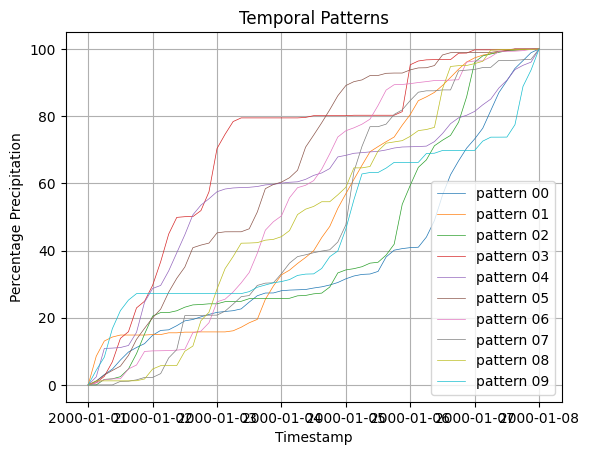

In [230]:
fig, ax = plt.subplots()

for col in asd.columns:
    ax.plot(
        asd.index.to_numpy(),
        asd[col].to_numpy(),
        linewidth=0.5,
        label=col
        )

ax.legend()
ax.grid(visible=True, which='both')
ax.set_title(label='Temporal Patterns')
ax.set_xlabel(xlabel='Timestamp')
ax.set_ylabel(ylabel='Percentage Precipitation')

In [235]:
asd = rain_data.prec_data[431].copy()
asd

,rain depth 00,rain depth 01,rain depth 02,rain depth 03,rain depth 04,rain depth 05,rain depth 06,rain depth 07,rain depth 08,rain depth 09
timestamp,,,,,,,,,,
2000-01-01 00:00:00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2000-01-01 03:00:00,7.5824,57.8835,0.0000,4.5359,16.2480,7.7178,4.1297,0.0000,8.1917,29.7203
2000-01-01 06:00:00,13.2692,30.5327,11.1705,12.6599,57.2065,12.1860,6.2961,0.0000,0.0000,26.2676
2000-01-01 09:00:00,10.9674,8.0563,1.0832,29.3141,0.7447,9.2072,1.7602,0.0000,0.0000,57.2742
2000-01-01 12:00:00,18.3467,4.0620,4.3328,47.2546,1.1509,8.7333,0.2708,7.1762,0.0000,36.4226
2000-01-01 15:00:00,16.1126,0.0000,15.5033,13.4723,4.1297,21.6640,19.7007,0.2708,0.0000,21.2578
2000-01-01 18:00:00,9.1395,0.0000,30.9389,47.9316,26.4030,32.3606,7.9209,2.7757,0.2708,12.9984
2000-01-01 21:00:00,7.7855,0.0000,39.6045,13.4723,60.8623,22.2056,27.4185,4.8067,3.5204,0.0000
2000-01-02 00:00:00,16.8573,0.8801,36.0164,32.0221,27.6216,21.1901,1.0832,0.0677,20.0392,0.0000


Text(0, 0.5, 'Precipitation Depth ($mm$)')

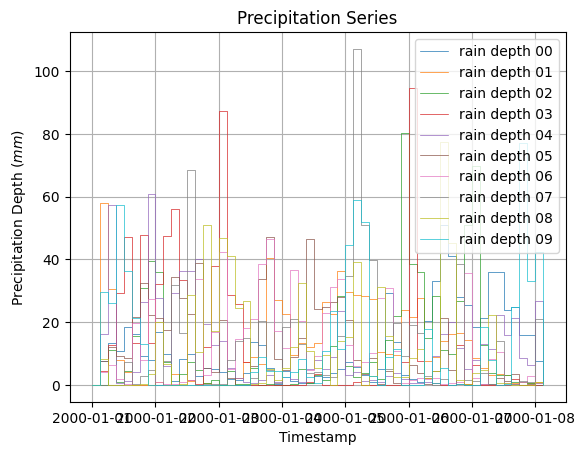

In [236]:
fig, ax = plt.subplots()

for col in asd.columns:
    # ax.plot(
    #     asd.index.to_numpy(),
    #     asd[col].to_numpy(),
    #     linewidth=0.5,
    #     label=col
    #     )
    ax.step(
        x=asd.index.to_numpy(),
        y=asd[col].to_numpy(),
        where='post',
        linewidth=0.5,
        label=col
        )

ax.legend()
ax.grid(visible=True, which='both')
ax.set_title(label='Precipitation Series')
ax.set_xlabel(xlabel='Timestamp')
ax.set_ylabel(ylabel='Precipitation Depth ($mm$)')

In [237]:
asd = rain_data.flow_data[431].copy()
asd

,flow rate 00,flow rate 01,flow rate 02,flow rate 03,flow rate 04,flow rate 05,flow rate 06,flow rate 07,flow rate 08,flow rate 09
timestamp,,,,,,,,,,
2000-01-01 00:05:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2000-01-01 00:10:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2000-01-01 00:15:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2000-01-01 00:20:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2000-01-01 00:25:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
2000-01-08 09:35:00,0.0,0.0,0.0,0.0,0.000070,0.0,0.0,0.000066,0.0,0.000073
2000-01-08 09:40:00,0.0,0.0,0.0,0.0,0.000063,0.0,0.0,0.000058,0.0,0.000071
2000-01-08 09:45:00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000064


(array([10957., 10958., 10959., 10960., 10961., 10962., 10963., 10964.]),
 [Text(10957.0, 0, '2000-01-01'),
  Text(10958.0, 0, '2000-01-02'),
  Text(10959.0, 0, '2000-01-03'),
  Text(10960.0, 0, '2000-01-04'),
  Text(10961.0, 0, '2000-01-05'),
  Text(10962.0, 0, '2000-01-06'),
  Text(10963.0, 0, '2000-01-07'),
  Text(10964.0, 0, '2000-01-08')])

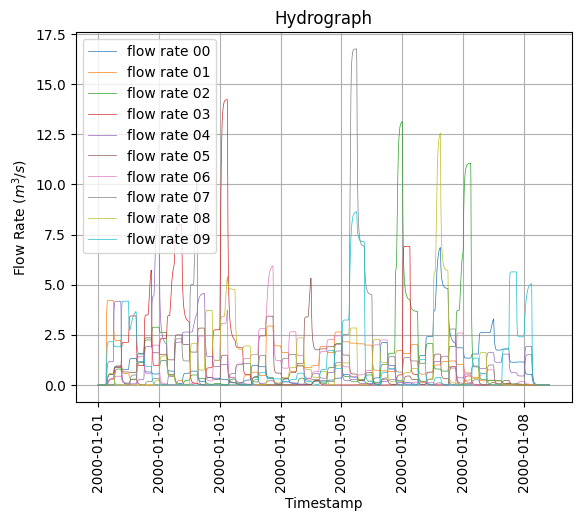

In [243]:
fig, ax = plt.subplots()

for col in asd.columns:
    ax.plot(
        asd.index.to_numpy(),
        asd[col].to_numpy(),
        linewidth=0.5,
        label=col
        )

ax.legend()
ax.grid(visible=True, which='both')
ax.set_title(label='Hydrograph')
ax.set_xlabel(xlabel='Timestamp')
ax.set_ylabel(ylabel='Flow Rate ($m^3/s$)')
# ax.set_xlim(right=asd.index.to_numpy()[0]+pd.Timedelta(minutes=30))
# ax.set_xticks(ticks=ax.get_xticks())
# ax.set_xticklabels(labels=pd.to_datetime(ax.get_xticks()), rotation='vertical')
plt.xticks(rotation='vertical')

In [ ]:
break

,date_time,rain_pattern
0,2000-01-01 00:00:00,0.0
1,2000-01-01 00:05:00,45.3
2,2000-01-01 00:10:00,100.0


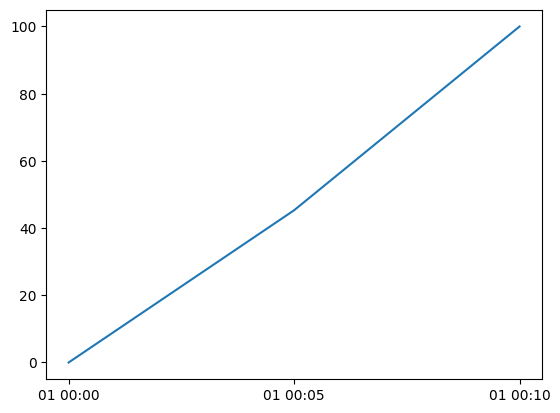

In [ ]:
ind = 9
rp = pd.read_parquet(path='{}rain_pattern__{}.parquet'.format(rain_pattern_cum_dir, rain_data.label[ind]))
plt.plot(rp.date_time.to_numpy(), rp.rain_pattern.to_numpy())
rp

,date_time,Value
0,2000-01-01 00:00:00,0.00000
1,2000-01-01 00:05:00,2.33295
2,2000-01-01 00:10:00,2.81705
3,2000-01-01 00:15:00,0.00000


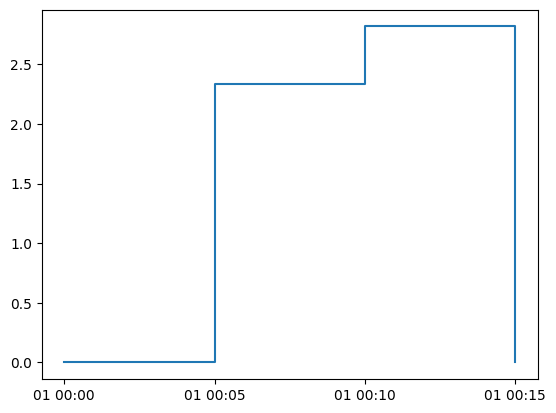

In [ ]:
pr = pd.read_parquet(path='{}prec__{}.parquet'.format(precipitation_dir, rain_data.label[ind]))
plt.step(
    x=pr.date_time.to_numpy(),
    y=pr.Value.to_numpy(),
    # x=np.concatenate((pr.date_time.to_numpy(), np.array(object=[pr.date_time.to_numpy()[-1] + np.diff(a=pr.date_time.to_numpy())[-1]]))),
    # y=np.concatenate((pr.Value.to_numpy(), np.array(object=[pr.Value.to_numpy()[-1]]))), 
    where='post'
    )
pr

In [ ]:
rain_data.time_series[0]

,Date,Time,Value
Name,,,
RainGauge,01/01/2000,00:00,0.00000
RainGauge,01/01/2000,00:05,2.99009
RainGauge,01/01/2000,00:10,2.15991
RainGauge,01/01/2000,00:15,0.00000


In [ ]:
rain_data.time_series[0].Value.sum()

5.15

In [ ]:
def create_inp_files(arg_label, arg_time_series, arg_time_step, arg_inp_file_dir, arg_inp_file_path, arg_rain_stopping_time, arg_timeseries_name):

    inp_file = '{}inp_file__{}.inp'.format(arg_inp_file_dir, arg_label)

    shutil.copyfile(src=arg_inp_file_path, dst=inp_file)

    end_date = pd.to_datetime(arg='{} {}'.format(arg_time_series.Date.iloc[-1], arg_time_series.Time.iloc[-1]), format='%m/%d/%Y %H:%M')
    end_date = end_date + arg_rain_stopping_time
    end_date, end_time = end_date.strftime(format='%m/%d/%Y'), end_date.strftime(format='%H:%M:%S')

    options_section = swmmio.utils.dataframes.dataframe_from_inp(inp_path=inp_file, section='[OPTIONS]')
    options_section.at['END_DATE', 'Value'] = end_date
    options_section.at['END_TIME', 'Value'] = end_time

    time_interval = str(pd.Timedelta(minutes=arg_time_step)).split(sep=' ')[-1].rsplit(sep=':', maxsplit=1)[0]

    raingauges_section = swmmio.utils.dataframes.dataframe_from_inp(inp_path=inp_file, section='[RAINGAGES]')
    raingauges_section.at[arg_timeseries_name, 'TimeIntrvl'] = time_interval

    [swmmio.utils.modify_model.replace_inp_section(inp_path=inp_file, modified_section_header=ind1, new_data=ind2)
    for ind1, ind2 in zip(
        ['[OPTIONS]', '[RAINGAGES]', '[TIMESERIES]'], 
        [options_section, raingauges_section, arg_time_series]
        )]

In [ ]:
rain_data.apply(
    func=lambda arg: create_inp_files(
        arg.label, arg.time_series, arg.time_step, inp_file_dir, inp_file_path, stopping_time_after_precipitation_finish, timeseries_name
        ),axis=1)
rain_data

0       None
1       None
2       None
3       None
4       None
        ... 
4315    None
4316    None
4317    None
4318    None
4319    None
Length: 4320, dtype: object

In [ ]:
def run_swmm(arg_inp_dir, arg_parquet_dir, arg_link, arg_label):

    model = '{}inp_file__{}.inp'.format(arg_inp_dir, arg_label)

    with Simulation(inputfile=model) as sim:
        link_sim = Links(model=sim)[arg_link]
        time_stamp = []
        flow_rate = []
        for ind2, step in enumerate(sim):
            time_stamp.append(sim.current_time)
            flow_rate.append(link_sim.flow)
        
        time_stamp = pd.Series(data=time_stamp, name='time_stamp')
        flow_rate = pd.Series(data=flow_rate, name='flow_rate')
        flow_rate_sim = pd.concat(objs=[time_stamp, flow_rate], axis=1)
        flow_rate_sim = flow_rate_sim[((flow_rate_sim.time_stamp.dt.minute %5 == 0)&(flow_rate_sim.time_stamp.dt.second == 0)) == True]
        flow_rate_sim.reset_index(drop=True, inplace=True)
        flow_rate_sim.to_parquet(path='{}flow_rate__{}.parquet'.format(arg_parquet_dir, arg_label))
        return flow_rate_sim.flow_rate.max()

In [ ]:
def run_multiprocessing(arg_df_label, arg_n_core=n_core, arg_max_tasks_per_child=100):

    n_task = len(arg_df_label)
    n_task_per_chunk = math.ceil(n_task/arg_n_core)

    with mp.Pool(processes=arg_n_core, maxtasksperchild=arg_max_tasks_per_child) as pool:
        outflow = [ind for ind in pool.starmap(func=run_swmm, iterable=arg_df_label, chunksize=n_task_per_chunk)]

    return pd.Series(data=outflow, name='max_flow_rate')

In [ ]:
rain_data['max_flow_rate'] = run_multiprocessing([(inp_file_dir, flow_rate_dir, link_to_get_results, ind) for ind in rain_data.label.to_list()], n_core)
rain_data

,duration,units,freq_window,label,duration_in_min,time_step,freq_label,freq_tag,depth,time_series,max_flow_rate
0,10.0,min,frequent,0000__00_0_00_0_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.092359
1,10.0,min,frequent,0001__00_0_00_1_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.095752
2,10.0,min,frequent,0002__00_0_00_2_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.097545
3,10.0,min,frequent,0003__00_0_00_3_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.090740
4,10.0,min,frequent,0004__00_0_00_4_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.092550
...,...,...,...,...,...,...,...,...,...,...,...
4315,168.0,hour,rare,4315__17_5_23_5_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,Date Time Value Name ...,5.326424
4316,168.0,hour,rare,4316__17_5_23_6_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,Date Time Value Name ...,5.930555
4317,168.0,hour,rare,4317__17_5_23_7_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,Date Time Value Name ...,16.754755
4318,168.0,hour,rare,4318__17_5_23_8_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,Date Time Value Name ...,12.556005


In [ ]:
rain_data.drop(columns='time_series', inplace=True)
rain_data.to_parquet(path='{}max_outflow.parquet'.format(output_dir))
rain_data

,duration,units,freq_window,label,duration_in_min,time_step,freq_label,freq_tag,depth,max_flow_rate
0,10.0,min,frequent,0000__00_0_00_0_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.092359
1,10.0,min,frequent,0001__00_0_00_1_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.095752
2,10.0,min,frequent,0002__00_0_00_2_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.097545
3,10.0,min,frequent,0003__00_0_00_3_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.090740
4,10.0,min,frequent,0004__00_0_00_4_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.092550
...,...,...,...,...,...,...,...,...,...,...
4315,168.0,hour,rare,4315__17_5_23_5_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,5.326424
4316,168.0,hour,rare,4316__17_5_23_6_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,5.930555
4317,168.0,hour,rare,4317__17_5_23_7_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,16.754755
4318,168.0,hour,rare,4318__17_5_23_8_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,12.556005


In [ ]:
len([len(rain_data[rain_data.freq_tag == ind]) for ind in rain_data.freq_tag.unique()])

18

In [ ]:
rain_data

,duration,units,freq_window,label,duration_in_min,time_step,freq_label,freq_tag,depth,max_flow_rate
0,10.0,min,frequent,0000__00_0_00_0_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.092359
1,10.0,min,frequent,0001__00_0_00_1_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.095752
2,10.0,min,frequent,0002__00_0_00_2_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.097545
3,10.0,min,frequent,0003__00_0_00_3_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.090740
4,10.0,min,frequent,0004__00_0_00_4_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.092550
...,...,...,...,...,...,...,...,...,...,...
4315,168.0,hour,rare,4315__17_5_23_5_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,5.326424
4316,168.0,hour,rare,4316__17_5_23_6_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,5.930555
4317,168.0,hour,rare,4317__17_5_23_7_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,16.754755
4318,168.0,hour,rare,4318__17_5_23_8_2__________rare__freq_1_in_200...,10080,180,1 in 2000,freq_1_in_2000,677.00,12.556005


In [ ]:
# asd = rain_data.copy().set_index(keys=['duration', 'units', 'duration_in_min', 'time_step', 'freq_label', 'freq_tag', 'depth'])
asd = rain_data.copy()
# asd.
# asd.set_index(keys=['freq_tag'], inplace=True)
# asd = pd.DataFrame(data=asd.groupby(by='freq_tag'), columns=['freq_tag', 'rain_data'])
# asd.rain_data.apply(func=lambda arg:)
asd = pd.DataFrame(data=asd.groupby(by=['freq_tag', 'freq_label', 'duration_in_min']), columns=['freq_dur', 'rain_data'])
asd[['freq_tag', 'freq_label', 'duration_in_min']] = asd.apply(func=lambda arg: (arg.freq_dur[0], arg.freq_dur[1], arg.freq_dur[2]), axis=1, result_type='expand')
asd.drop(columns='freq_dur', inplace=True)
asd

,rain_data,freq_tag,freq_label,duration_in_min
0,duration units freq_window \ 2160 ...,freq_0_2EY,0.2EY,10
1,duration units freq_window \ 2170 ...,freq_0_2EY,0.2EY,15
2,duration units freq_window \ 2180 ...,freq_0_2EY,0.2EY,20
3,duration units freq_window \ 2190 ...,freq_0_2EY,0.2EY,25
4,duration units freq_window \ 2200 ...,freq_0_2EY,0.2EY,30
...,...,...,...,...
427,duration units freq_window \ 430 72...,freq_6EY,6EY,4320
428,duration units freq_window \ 440 96...,freq_6EY,6EY,5760
429,duration units freq_window \ 450 120...,freq_6EY,6EY,7200
430,duration units freq_window \ 460 144...,freq_6EY,6EY,8640


In [ ]:
asd.rain_data[0]

,duration,units,freq_window,label,duration_in_min,time_step,freq_label,freq_tag,depth,max_flow_rate
2160,10.0,min,frequent,2160__09_0_00_0_0______frequent______freq_0_2E...,10,5,0.2EY,freq_0_2EY,18.0,14.284206
2161,10.0,min,frequent,2161__09_0_00_1_0______frequent______freq_0_2E...,10,5,0.2EY,freq_0_2EY,18.0,14.954895
2162,10.0,min,frequent,2162__09_0_00_2_0______frequent______freq_0_2E...,10,5,0.2EY,freq_0_2EY,18.0,14.739794
2163,10.0,min,frequent,2163__09_0_00_3_0______frequent______freq_0_2E...,10,5,0.2EY,freq_0_2EY,18.0,15.018733
2164,10.0,min,frequent,2164__09_0_00_4_0______frequent______freq_0_2E...,10,5,0.2EY,freq_0_2EY,18.0,14.680215
2165,10.0,min,frequent,2165__09_0_00_5_0______frequent______freq_0_2E...,10,5,0.2EY,freq_0_2EY,18.0,15.894704
2166,10.0,min,frequent,2166__09_0_00_6_0______frequent______freq_0_2E...,10,5,0.2EY,freq_0_2EY,18.0,15.735044
2167,10.0,min,frequent,2167__09_0_00_7_0______frequent______freq_0_2E...,10,5,0.2EY,freq_0_2EY,18.0,15.246494
2168,10.0,min,frequent,2168__09_0_00_8_0______frequent______freq_0_2E...,10,5,0.2EY,freq_0_2EY,18.0,16.515567
2169,10.0,min,frequent,2169__09_0_00_9_0______frequent______freq_0_2E...,10,5,0.2EY,freq_0_2EY,18.0,15.713777


In [ ]:
qwe = asd.rain_data[0].copy()
qwe.reset_index(drop=True, inplace=True)
qwe['pattern'] = pd.Series(data=['pattern_{:02}'.format(ind) for ind in range(len(qwe))])
qwe.set_index(keys=['duration', 'units', 'freq_window', 'time_step', 'depth', 'pattern'], inplace=True)
qwe.drop(columns=['label', 'duration_in_min', 'freq_label', 'freq_tag'], inplace=True)
# qwe.unstack(level=5)

qwe

max_flow_rate
duration units freq_window time_step depth pattern                  
10.0     min   frequent    5         18.0  pattern_00      14.284206
                                           pattern_01      14.954895
                                           pattern_02      14.739794
                                           pattern_03      15.018733
                                           pattern_04      14.680215
                                           pattern_05      15.894704
                                           pattern_06      15.735044
                                           pattern_07      15.246494
                                           pattern_08      16.515567
                                           pattern_09      15.713777

In [ ]:
pd.DataFrame(data=asd.rain_data[0].groupby(by='duration_in_min'), columns=['duration_in_min', 'rain_data'])

,duration_in_min,rain_data
0,10,duration units freq_window \ 2160 ...
1,15,duration units freq_window \ 2170 ...
2,20,duration units freq_window \ 2180 ...
3,25,duration units freq_window \ 2190 ...
4,30,duration units freq_window \ 2200 ...
5,45,duration units freq_window \ 2210 ...
6,60,duration units freq_window \ 2220 ...
7,90,duration units freq_window \ 2230 ...
8,120,duration units freq_window \ 2240 ...
9,180,duration units freq_window \ 2250 ...


In [ ]:
asd.unstack(level=0)

ValueError: Columns with duplicate values are not supported in stack

In [ ]:
rain_data[rain_data.freq_tag == 'freq_12EY']

,duration,units,freq_window,label,duration_in_min,time_step,freq_label,freq_tag,depth,max_flow_rate
0,10.0,min,frequent,0000__00_0_00_0_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.092359
1,10.0,min,frequent,0001__00_0_00_1_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.095752
2,10.0,min,frequent,0002__00_0_00_2_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.097545
3,10.0,min,frequent,0003__00_0_00_3_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.090740
4,10.0,min,frequent,0004__00_0_00_4_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,3.092550
...,...,...,...,...,...,...,...,...,...,...
235,168.0,hour,frequent,0235__00_5_23_5_0______frequent_______freq_12E...,10080,180,12EY,freq_12EY,47.50,0.371345
236,168.0,hour,frequent,0236__00_5_23_6_0______frequent_______freq_12E...,10080,180,12EY,freq_12EY,47.50,0.540534
237,168.0,hour,frequent,0237__00_5_23_7_0______frequent_______freq_12E...,10080,180,12EY,freq_12EY,47.50,0.392405
238,168.0,hour,frequent,0238__00_5_23_8_0______frequent_______freq_12E...,10080,180,12EY,freq_12EY,47.50,0.339038


In [ ]:
a = 0
b = 60
rain_data.iloc[a:a+b]

,duration,units,freq_window,label,duration_in_min,time_step,freq_label,freq_tag,depth,time_series,max_flow_rate
0,10.0,min,frequent,0000__00_0_00_0_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.092359
1,10.0,min,frequent,0001__00_0_00_1_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.095752
2,10.0,min,frequent,0002__00_0_00_2_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.097545
3,10.0,min,frequent,0003__00_0_00_3_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.090740
4,10.0,min,frequent,0004__00_0_00_4_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.092550
5,10.0,min,frequent,0005__00_0_00_5_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.047926
6,10.0,min,frequent,0006__00_0_00_6_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.075615
7,10.0,min,frequent,0007__00_0_00_7_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.075938
8,10.0,min,frequent,0008__00_0_00_8_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,2.968448
9,10.0,min,frequent,0009__00_0_00_9_0______frequent_______freq_12E...,10,5,12EY,freq_12EY,5.15,Date Time Value Name ...,3.066527
